# The Rise of the A.I. Guardians

## Year: 3075
### Background:
<div style="display: flex; align-items: center;">
    <div style="max-width: 600px; text-align:justify;">
        <p>
            Humanity’s exodus to Earth Junior was a success—thanks to your incredible screening model. Over generations, humans have adapted to their new home, and peace has settled on Earth Junior. However, something strange has begun to occur among the advanced humanoid machines, called <code>Guardians</code>, who have served as protectors and caretakers for decades. Recently, a strange glitch has been detected in some Guardians. They exhibit erratic behaviors that resemble the old zombie behaviors from Earth. Scientists call this phenomenon <code>Code Rot</code> — an anomaly in the neural networks controlling the Guardians, possibly due to lingering cosmic radiation or a mysterious extraterrestrial virus.
        </p>
        <p>
            As humanity’s chief machine learning engineer, you're tasked with identifying Guardians at risk of Code Rot. Using a neural network model, you need to predict which Guardians might develop this infection-like behavior. A high <code>Code Rot probability</code> indicates the Guardian is likely to malfunction, while a low score suggests it's safe.
        </p>
        <p>
            <strong><i>The mission is clear:</i></strong> Identify and quarantine any malfunctioning Guardians before they jeopardize the safety of Earth Junior's inhabitants. But beware—time is limited, and the fate of humanity once again rests on your neural network’s ability to separate friend from foe.
        </p>
    </div>
    <img src="data/image.png" alt="Guardian Image" width="450" style="margin-left: 20px;">
</div>


# PA3 [100 Marks]
### Problem Statement: 

In this project, you are required to implement a binary classifier to predict whether a Guardian (humanoid machine) is infected with **Code Rot**—a malfunction that causes erratic behavior similar to a zombie-like state. The classifier should determine whether each Guardian is safe or infected based on CT scan images.

#### Data:
- You have been provided with **8580 CT scan images** of Guardians.
- A **CSV file** contains labels indicating whether each image corresponds to a malfunctioning (infected) Guardian or not.
  
Your task is to develop a model that can accurately predict **whether there is infection or not** in these Guardians based on their CT scan images, and assess the performance of your classifier using appropriate metrics. You can choose between pytorch, keras or tensorflow to implement your model.

# Import necessary libraries

In [ ]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import random
from collections import Counter
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
np.random.seed(133)

# Loading Data  [10 Marks]
Load the images, labels and preprocess as necessary.

In [13]:
csv_path = 'labels.csv'
labels_df = pd.read_csv(csv_path)
labels_df['infected'] = labels_df['infected'].map({'yes': 1, 'no': 0})
image_dir = 'HeadCT/'
image_size = (128, 128)

images = []
labels = []

for index, row in labels_df.iterrows():
    image_path = f"{image_dir}{row['filename']}"
    image = cv2.imread(image_path)
    if image is None:
        print(f"Image not found: {image_path}")
        continue
    image = cv2.resize(image, image_size)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    images.append(image)
    labels.append(row['infected'])

In [14]:
X = np.array(images)
Y = np.array(labels)

# Visualizing Data [5 Marks]
- Make a function to plot a set of random images with class labels
- Plot the class distribution

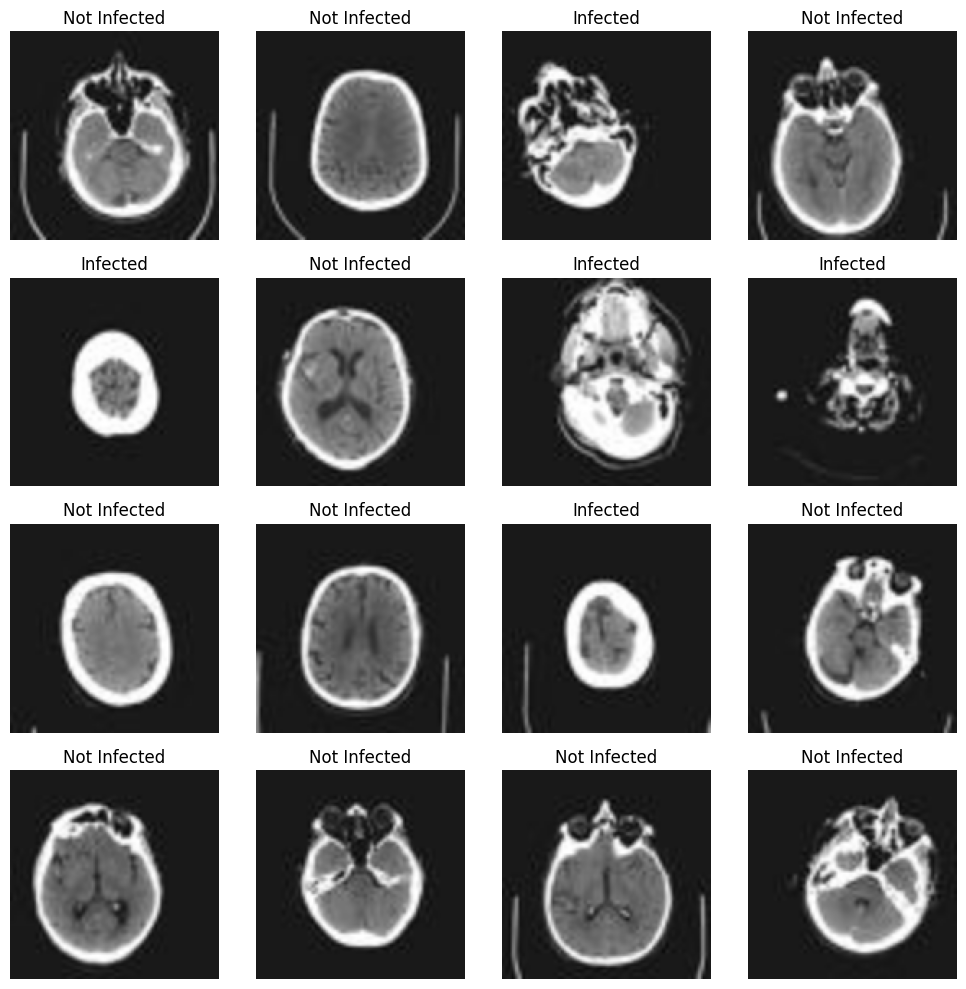

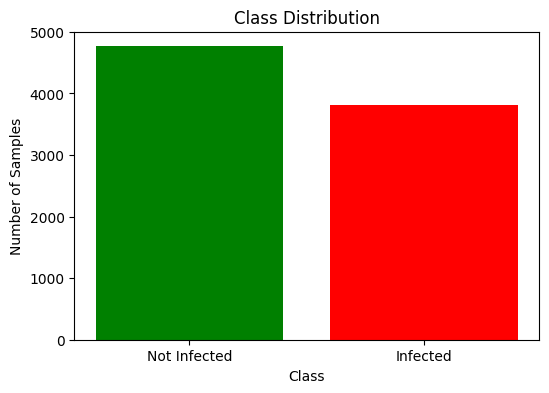

In [ ]:
def plot_random_images(images, labels, class_names, num_images=16):
    plt.figure(figsize=(10, 10))
    selected_indices = random.sample(range(len(images)), num_images)
    for i, idx in enumerate(selected_indices):
        plt.subplot(4, 4, i + 1)
        plt.imshow(images[idx])
        plt.title(class_names[labels[idx]])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

def plot_class_distribution(labels, class_names):
    counts = Counter(labels)
    classes = [class_names[c] for c in counts.keys()]
    values = list(counts.values())

    plt.figure(figsize=(6, 4))
    plt.bar(classes, values, color=['green', 'red'])
    plt.xlabel('Class')
    plt.ylabel('Number of Samples')
    plt.title('Class Distribution')
    plt.show()

class_names = {0: 'Not Infected', 1: 'Infected'}
plot_random_images(images, labels, class_names, num_images=16)
plot_class_distribution(labels, class_names)


# Train/test split and Normalization [20 marks]
- Perform train, test, val split of a suitable ratio
- Implement a suitable scaler class to normalize the data

In [15]:
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.3, random_state=42, stratify=Y)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42, stratify=Y_temp)

print("Training set shape:", X_train.shape, Y_train.shape)
print("Validation set shape:", X_val.shape, Y_val.shape)
print("Testing set shape:", X_test.shape, Y_test.shape)

class NormalizationScaler:
    def fit(self, X):
        pass

    def transform(self, X):
        return X / 255.0

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)
    
scaler = NormalizationScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

Training set shape: (6006, 128, 128, 3) (6006,)
Validation set shape: (1287, 128, 128, 3) (1287,)
Testing set shape: (1287, 128, 128, 3) (1287,)


# Create a BinaryClassifier class (10 Marks)
- Define a model class, initialize layers with activations as required
- Define a suitable loss function and learning rate

In [8]:
class BinaryClassifier(nn.Module):
    def __init__(self, input_dims):
        super(BinaryClassifier, self).__init__()
        self.input_dims = input_dims
        self.model = nn.Sequential(
            nn.Linear(input_dims, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.model(x)

# Training Loop [25 marks]
1. **`fit_one_epoch`**: Performs one epoch of training  [5]
  
2. **`evaluate`**: Evaluates the model on the validation set. [10]
 
3. **`fit`**: Run all epochs, recording training and validation accuracies and losses [10]

In [ ]:
def fit_one_epoch(model, X, y, optimizer, loss_fn, batch_size=64):
    model.train()
    total_loss = 0
    correct = 0
    num_samples = len(y)

    for i in range(0, len(X), batch_size):  
        inputs = X[i:i+batch_size]
        targets = y[i:i+batch_size]
        
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        total_loss += loss.item() * len(inputs)
        preds = (outputs > 0.5).float()
        correct += (preds == targets).sum().item()
    
    avg_loss = total_loss / num_samples
    accuracy = correct / num_samples
    return avg_loss, accuracy

@torch.no_grad()
def evaluate(model, X, y, loss_fn, batch_size=64):
    model.eval()
    total_loss = 0
    correct = 0
    num_samples = len(y)

    for i in range(0, len(X), batch_size):
        inputs = X[i:i+batch_size]
        targets = y[i:i+batch_size]
        
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        total_loss += loss.item() * len(inputs)
        preds = (outputs > 0.5).float()
        correct += (preds == targets).sum().item()
    
    avg_loss = total_loss / num_samples
    accuracy = correct / num_samples
    return avg_loss, accuracy

def fit(model, X_train, y_train, X_val, y_val, optimizer, loss_fn, epochs, batch_size=64):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        
        train_loss, train_acc = fit_one_epoch(model, X_train, y_train, optimizer, loss_fn, batch_size)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_loss, val_acc = evaluate(model, X_val, y_val, loss_fn, batch_size)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}\n")
        
    return train_losses, train_accuracies, val_losses, val_accuracies


In [16]:
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).view(-1, 128 * 128 * 3)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32).view(-1, 128 * 128 * 3)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).view(-1, 128 * 128 * 3)

Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32).unsqueeze(1)
Y_val_tensor = torch.tensor(Y_val, dtype=torch.float32).unsqueeze(1)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32).unsqueeze(1)


In [33]:
input_dims = 128 * 128 * 3
model = BinaryClassifier(input_dims)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 10
batch_size = 3000

train_losses, train_accuracies, val_losses, val_accuracies = fit(model, X_train_tensor, Y_train_tensor, X_val_tensor, Y_val_tensor, optimizer, loss_fn, epochs, batch_size)

Epoch 1/10
Train Loss: 1.2939, Train Accuracy: 0.4937
Val Loss: 0.6388, Val Accuracy: 0.5548

Epoch 2/10
Train Loss: 0.7058, Train Accuracy: 0.5553
Val Loss: 0.4174, Val Accuracy: 0.7490

Epoch 3/10
Train Loss: 0.3652, Train Accuracy: 0.8585
Val Loss: 0.2349, Val Accuracy: 0.9736

Epoch 4/10
Train Loss: 0.2346, Train Accuracy: 0.9559
Val Loss: 0.2727, Val Accuracy: 0.8609

Epoch 5/10
Train Loss: 0.2377, Train Accuracy: 0.8979
Val Loss: 0.1750, Val Accuracy: 0.9285

Epoch 6/10
Train Loss: 0.1783, Train Accuracy: 0.9252
Val Loss: 0.1089, Val Accuracy: 0.9736

Epoch 7/10
Train Loss: 0.1186, Train Accuracy: 0.9655
Val Loss: 0.1201, Val Accuracy: 0.9596

Epoch 8/10
Train Loss: 0.1188, Train Accuracy: 0.9575
Val Loss: 0.0905, Val Accuracy: 0.9713

Epoch 9/10
Train Loss: 0.0995, Train Accuracy: 0.9624
Val Loss: 0.0800, Val Accuracy: 0.9736

Epoch 10/10
Train Loss: 0.0821, Train Accuracy: 0.9727
Val Loss: 0.0777, Val Accuracy: 0.9720



# Plot Accuracy and Loss Curves  [10 marks]

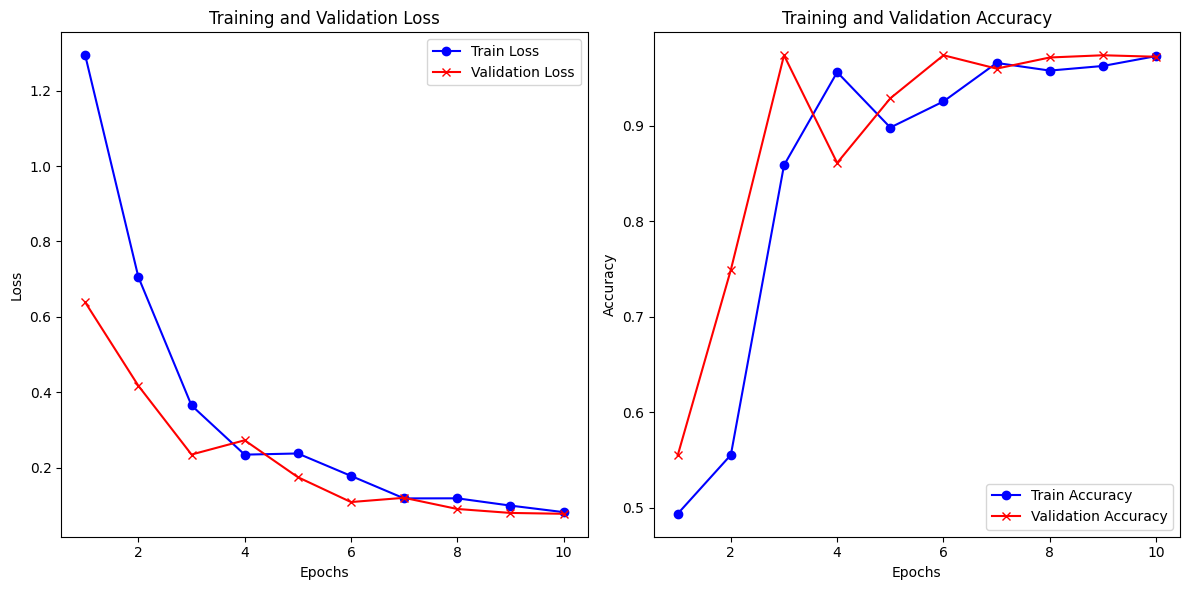

In [34]:
def plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies):
    epochs = len(train_losses)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    ax1.plot(range(1, epochs + 1), train_losses, label='Train Loss', color='blue', marker='o')
    ax1.plot(range(1, epochs + 1), val_losses, label='Validation Loss', color='red', marker='x')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    ax2.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy', color='blue', marker='o')
    ax2.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy', color='red', marker='x')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.tight_layout()
    plt.show()

plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies)

# Evaluate on the test set [5 marks]

In [35]:
test_loss, test_accuracy = evaluate(model, X_test_tensor, Y_test_tensor, loss_fn)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Loss: 0.0782
Test Accuracy: 0.9736


# Evaluation Metrics [10 marks]
- Classification Report
- Confusion Matrix
- ROC Curve

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       715
           1       0.99      0.95      0.97       572

    accuracy                           0.97      1287
   macro avg       0.98      0.97      0.97      1287
weighted avg       0.97      0.97      0.97      1287



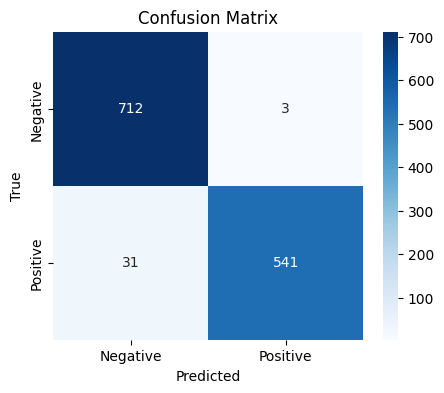

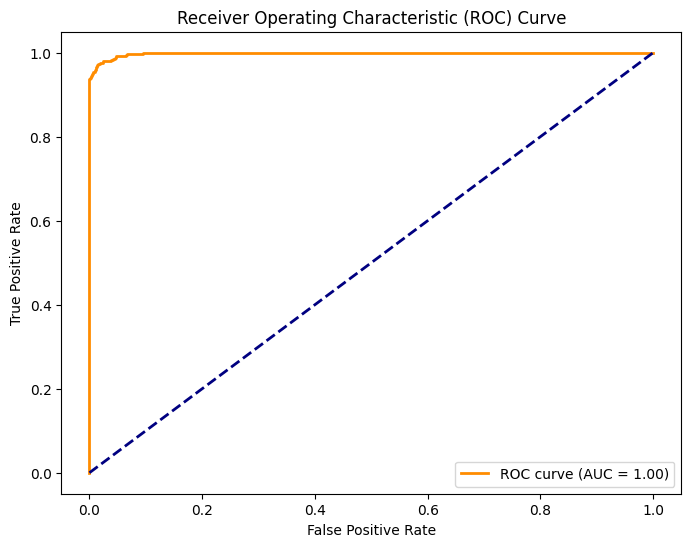

In [36]:
y_pred = (model(X_test_tensor).detach().numpy() > 0.5).astype(int)
y_true = Y_test_tensor.detach().numpy().astype(int)
print(classification_report(y_true, y_pred))


cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


fpr, tpr, _ = roc_curve(y_true, model(X_test_tensor).detach().numpy())
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


# Where did it go wrong?  [5 marks]
Plot images that were missclassified by the model to see where it struggled to differentiate between the classes

Number of Type I Errors (False Positives): 3


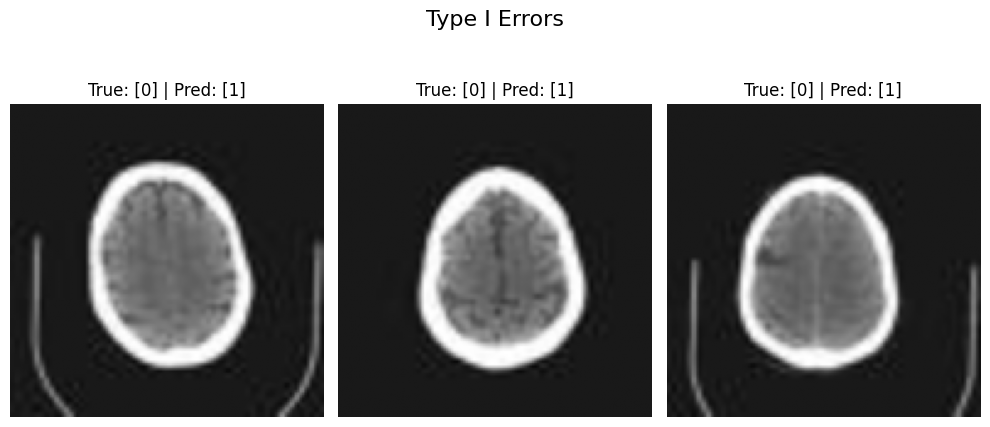

Number of Type II Errors (False Negatives): 31


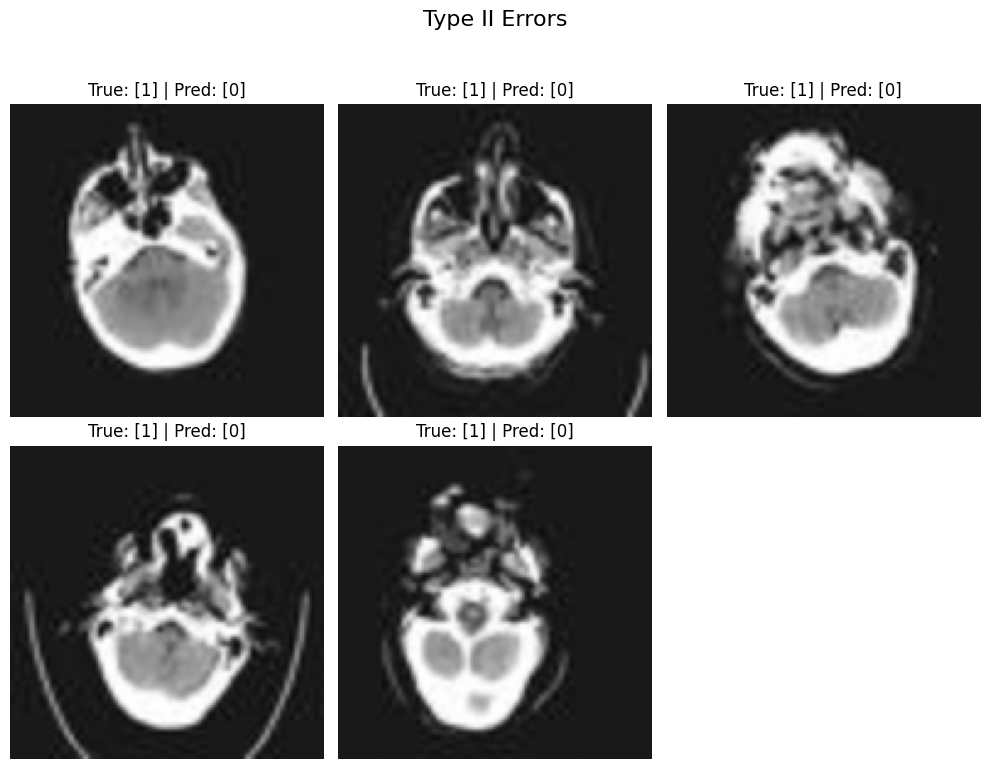

In [41]:
def plot_error_images(indices, images, true_labels, predicted_labels, error_type, num_images=5):
    plt.figure(figsize=(10, 8))
    for i, idx in enumerate(indices[:num_images]):
        plt.subplot(2, 3, i + 1)
        img = images[idx].reshape(128, 128, 3)
        plt.imshow(img)
        plt.title(f"True: {true_labels[idx]} | Pred: {predicted_labels[idx]}")
        plt.axis('off')
    plt.suptitle(f"{error_type} Errors", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

false_positive_indices = np.where((y_pred == 1) & (y_true == 0))[0]
false_negative_indices = np.where((y_pred == 0) & (y_true == 1))[0]

print(f"Number of Type I Errors (False Positives): {len(false_positive_indices)}")
plot_error_images(false_positive_indices, X_test_scaled, y_true, y_pred, "Type I")
print(f"Number of Type II Errors (False Negatives): {len(false_negative_indices)}")
plot_error_images(false_negative_indices, X_test_scaled, y_true, y_pred, "Type II")


## Well done, Guardian Protector! 🎉

Your model has successfully safeguarded Earth Junior from Code Rot, ensuring few more years of peace and security. Humanity owes you a debt of gratitude—for your work to keep them safe! 🛡️